In [1]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import KFold
import numpy as np

## Read in data
Seperating the attributes from the result

In [2]:
file = pd.read_csv("heart_data.txt")

cols = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']
data = pd.DataFrame([file[col] for col in cols]).T
famhist = [1 if val == 'Present' else 0 for val in file['famhist']]
data['famhist'] = famhist
data = pd.DataFrame(zscore(data, ddof=1))
cols.append('famhist')
data.columns = cols

data

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,famhist
0,1.057417,1.821099,0.477894,-0.295183,-0.418017,-0.176594,3.274189,0.628654,1.184570
1,0.276789,-0.789382,-0.159507,0.411694,0.193134,0.670646,-0.612081,1.381617,-0.842361
2,-0.991731,-0.774141,-0.608585,0.883374,-0.112441,0.734723,-0.540597,0.217947,1.184570
3,1.545310,0.841352,0.806252,1.622382,-0.214300,1.411091,0.294742,1.039361,1.184570
4,-0.211103,2.169453,-0.598928,0.305020,0.702427,-0.012842,1.645991,0.423301,1.184570
...,...,...,...,...,...,...,...,...,...
457,3.692037,-0.704470,0.598614,0.811401,1.109862,0.570971,-0.696228,1.039361,-0.842361
458,2.130781,0.122871,-0.159507,0.860240,-0.112441,0.608942,0.068445,0.628654,-0.842361
459,-1.479624,-0.138395,-1.521228,-1.307946,-1.334744,-1.413043,0.391960,0.834008,-0.842361
460,-0.991731,0.384137,3.317227,0.691875,1.109862,0.309916,0.282897,-0.192760,-0.842361


## Define test and train data
Getting the test and train data values based on a simple slice (k-fold could be used here)

Data is mapped as torch tensors with floats

In [3]:
train_size = 0.9
split_idx = int(len(data) * train_size)
x_train, x_test = map(torch.tensor, ((data.iloc[:split_idx].values), (data.iloc[split_idx:].values)))
y_train, y_test = map(torch.tensor, ((file['chd'][:split_idx].values), (file['chd'][split_idx:].values)))
x_train, x_test, y_train, y_test = x_train.float(), x_test.float(), y_train.float(), y_test.float()

In [4]:
n_input, n_hidden, n_out, learning_rate = 9, 1, 1, 0.1

model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())

print("ANN model, this could be changed to other values")
print(model)

ANN model, this could be changed to other values
Sequential(
  (0): Linear(in_features=9, out_features=1, bias=True)
  (1): Linear(in_features=1, out_features=1, bias=True)
  (2): Sigmoid()
)


## NN loop
This is the actual loop running the machine learning model

In [5]:
# number of folds
k = 10

# number of runs for each fold
epochs = 400

# hidden units
step = 2
h = np.arange(start = 0, stop = k * step,step = step, dtype=int) + 1

# hyperparameters for model
n_input, n_out, learning_rate = len(data.columns), 1, 0.1

# indices for k-folded data
splits=KFold(n_splits= k)

In [12]:
def ANN_model(k, epochs, h, n_input, n_out, lr, data, vals):
    train_cost, test_cost = np.empty(shape=(k,epochs)), np.empty(shape=(k,epochs))
    for i, (train_idx, test_idx) in enumerate(splits.split(data)):
        
        # Defining the model for each fold
        model = nn.Sequential(nn.Linear(n_input, h[i]),
                            nn.Linear(h[i], n_out),
                            nn.Sigmoid())
        loss_function = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        
        # Getting the k-folded data
        x_train, x_test = map(torch.tensor, ((data.iloc[train_idx].values), (data.iloc[test_idx].values)))
        y_train, y_test = map(torch.tensor, ((vals.iloc[train_idx].values), (vals.iloc[test_idx].values)))
        x_train, x_test, y_train, y_test = x_train.float(), x_test.float(), y_train.float(), y_test.float()
        
        # Running model
        for j in range(epochs):
            pred_y = model(x_train)
            loss = loss_function(pred_y.flatten(), y_train)
            train_cost[i][j] = loss

            pred_y_test = model(x_test)
            loss_test = loss_function(pred_y_test.flatten(), y_test)
            test_cost[i][j] = loss_test
            
            model.zero_grad()
            loss.backward()

            optimizer.step()
    
    return train_cost, test_cost

train_cost, test_cost = ANN_model(k, epochs, h, n_input, n_out, learning_rate, data, file['chd'])
        

## Loss plots

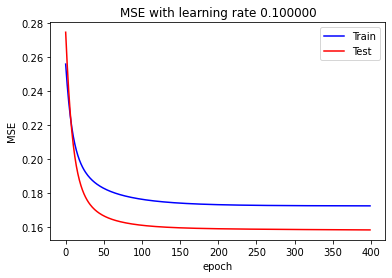

In [13]:
plt.plot(train_cost[-1], 'b', label="Train")
plt.plot(test_cost[-1], 'r', label="Test")
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title("MSE with learning rate %f"%(learning_rate))
plt.show()

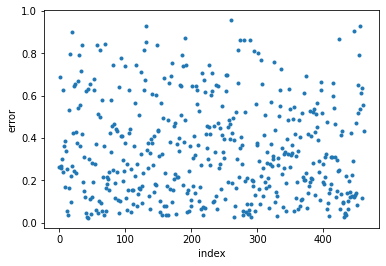

In [8]:
errs = [abs(float(model(torch.tensor(data.iloc[idx].values).float()) - file['chd'][idx])) for idx in range(len(data))]
plt.plot(errs, '.')
plt.ylabel("error")
plt.xlabel("index")
plt.show()

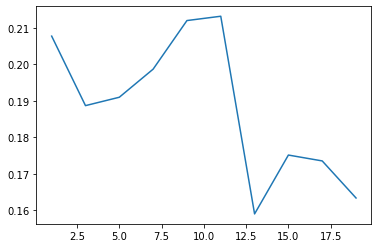

In [14]:
plt.plot(h, [np.mean(x) for x in test_cost])
plt.show()